In [1]:
import pandas as pd
import numpy as np
import os, sys, glob
from pathlib import Path
from scipy.interpolate import interp2d
from emgineer import EmgDecomposition
import matplotlib.pyplot as plt

from scipy import stats
import math

import plotly.graph_objects as go
from calc_fr import st2fr, label_fr

import pickle, json
from sklearn.metrics.pairwise import cosine_similarity

sys.path.append('../load_intan_rhd_format')

from load_filt_test import read_data, guolv

def filt_all_rhd(path):
    rhd = read_data(path)
    array_emg = rhd['amplifier_data']
    array_emg = array_emg[:, 2000:]
    array_emg_filt = guolv(array_emg).T
    return array_emg_filt

def rms(x, axis=None):
    return np.sqrt(np.mean(x**2, axis=axis))

In [2]:
def plot_spikes_plus(spikes,
                fr_filename,
                stride=0,
                win=None):
    if win is not None:
        spikes = spikes[win:]
    x_s = (np.arange(spikes.shape[0]) ) /2048
    cmap = ['#de3c3a', '#de9c3a', '#d8de3a', '#70de3a', '#3ade79', '#3adedb', '#3a7bde', '#633ade', '#d33ade', '#de3a86']# plt.get_cmap("tab10")
    i_c = 0
    for i in range(spikes.shape[1]):
        spike_row = spikes[:, i]
        if i_c >= len(cmap):
            i_c = 0
        color = cmap[i_c]
        i_c += 1
        for j in range(spikes.shape[0]):
            if spike_row[j] == 1:
                _x = x_s[j]
                plt.plot([_x, _x], [i+0.1, i+0.9], color=color, lw=1)
    # plt.title(title)
    
    
    plt.yticks(np.arange(1, spikes.shape[1] + 1,1),['' for x in np.arange(1, spikes.shape[1] + 1,1)])
    plt.grid(axis='y', alpha=0.3)
    mu_index = np.arange(spikes.shape[1],0, -1)
    for i, mu_i in enumerate(mu_index):
        plt.text(-0.02 * x_s[x_s.shape[0] - 1], i + 0.3, str(mu_i))
    plt.ylabel('Index of Motor Unit', labelpad=20)
    plt.xlabel('time[s]')
    plt.xlim(0, x_s[x_s.shape[0] - 1])

    df_fr = pd.read_csv(fr_filename, index_col=None, header=0)
    label = df_fr['label'].diff().map(np.abs)
    index_comb_start_end = np.where(label.values != 0)[0][1:]
    label_comb_start_end = label.values[index_comb_start_end].reshape(-1, 2)[:, 0] -1
    time_comb_start_end = ((index_comb_start_end + stride) /2048).reshape(-1, 2)
    colors = ['r','orange','limegreen','darkturquoise','indigo']
    for label, comb in zip(label_comb_start_end, time_comb_start_end):
        if len(np.unique(label_comb_start_end)) == 4:
            label += 1
        plt.axvspan(comb[0], comb[1], facecolor=colors[int(label)], alpha=0.15)
    

# MUST 描画

In [3]:
df_filename = pd.read_csv('table_filename.csv', index_col=0, header=0)


Reading Intan Technologies RHD2000 Data File, Version 3.0

n signal groups 11
Found 128 amplifier channels.
Found 6 auxiliary input channels.
Found 0 supply voltage channels.
Found 0 board ADC channels.
Found 0 board digital input channels.
Found 0 board digital output channels.
Found 0 temperature sensors channels.

File contains 24.704 seconds of data.  Amplifiers were sampled at 2.00 kS/s.

Allocating memory for data...
Reading data from file...
10% done...
20% done...
30% done...
40% done...
50% done...
60% done...
70% done...
80% done...
90% done...
Parsing data...
No missing timestamps in data.
Done!  Elapsed time: 0.4 seconds
start decomp
end decomp


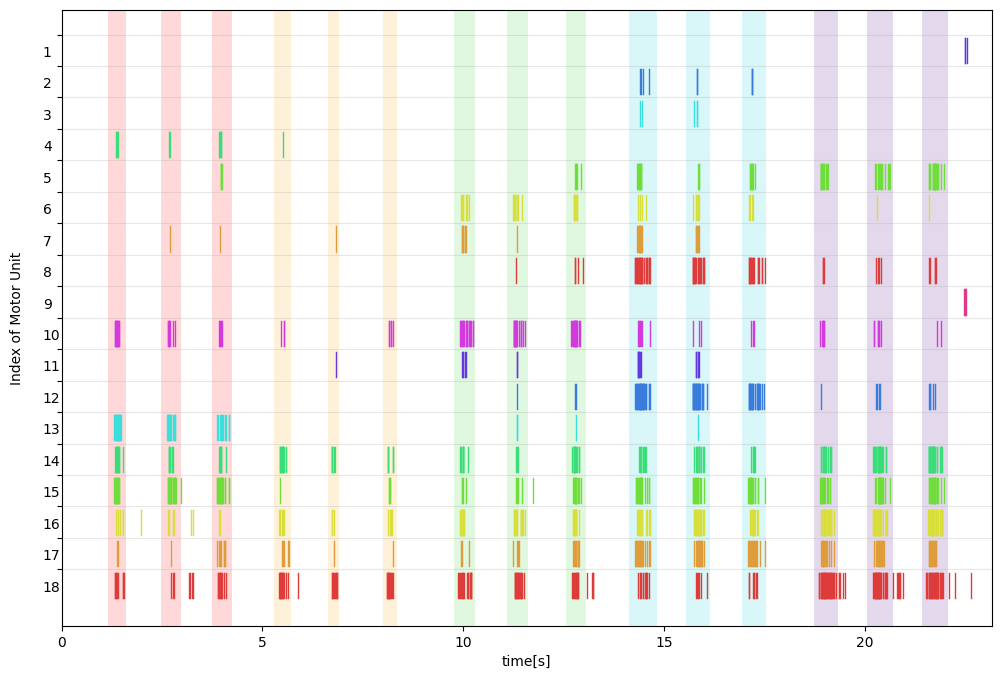

In [4]:
# param
n_motor_unit = 20
subject_name = 'tei'
motion_name = 'five'
motion_index = 0
is_ext = 0

path_root = glob.glob(f'G:/共有ドライブ/MFG/project/Biomedical engineering/Project プロジェクト/Bionic hand/EMG実験/2022*_{subject_name}')[0]
filename = df_filename[subject_name][motion_name + '_' + str(motion_index)]
path = f'{path_root}/{filename}/{filename}.rhd'
emg_filt = filt_all_rhd(path)

cashe = subject_name +'_' + filename + '_mu' + str(n_motor_unit)
if is_ext:
    chashe = cashe + '_ext'
    emg_tmp = emg_filt[:, 64:]
else:
    emg_tmp = emg_filt[:, :64]

# decomp
print('start decomp')
est_flex = EmgDecomposition(
    n_motor_unit=n_motor_unit,
    n_delayed=8,
    random_state=0,
    cashe= cashe,
    flag_sil=True,
    flag_pca=False)
est_flex.fit(emg_tmp)
st_flex, mu_flex = est_flex.transform(emg_tmp)

print('end decomp')
plt.rcParams['figure.figsize'] = (12.0, 8.0)
plot_spikes_plus(st_flex[:, :20][:, ::-1], fr_filename=f'fr_{motion_name}/fr_{subject_name}_{motion_index}.csv', stride=768/2)


# FR heatmap

In [26]:
subjects = ['tei']*2 +['li'] * 2 + ['nakashima'] * 2 + ['zhang'] * 2
motion_indexes = [0,1,0,0,0,1,0,1]
motions = ['five', 'imrl'] * 4
n_motor_unit = 20

list_meanFR_flex = []
list_meanFR_ext = []

subject_name = 'zhang'
motion_name = 'imrl'

for j, (_s, _i, _m) in enumerate(zip(subjects, motion_indexes, motions)):
    if _s == subject_name:
        if _m == motion_name:
            print(j)
            path_root = glob.glob(f'G:/共有ドライブ/MFG/project/Biomedical engineering/Project プロジェクト/Bionic hand/EMG実験/2022*_{_s}')[0]
            filename = df_filename[_s][_m + '_' + str(_i)]
            path = f'{path_root}/{filename}/{filename}.rhd'
            emg_filt = filt_all_rhd(path)

            cashe = _s +'_' + filename + '_mu' + str(n_motor_unit)
            emg_tmp = emg_filt[:, :64]        

            # decomp
            est_ = EmgDecomposition(
                n_motor_unit=n_motor_unit,
                n_delayed=8,
                random_state=0,
                cashe= cashe,
                flag_sil=True,
                flag_pca=False)
            est_.fit(emg_tmp)
            st_, mu_ = est_.transform(emg_tmp)

            df_fr = pd.read_csv(f'fr_{_m}/fr_{_s}_{_i}.csv', index_col=None, header=0)
            label = df_fr['label'].diff().map(np.abs)
            index_comb_start_end = (np.where(label.values != 0)[0][1:] + 768).reshape(-1, 6)
            for k, comb in enumerate(index_comb_start_end):
                
                sum_1 = st_[comb[0]:comb[1],:].sum(axis=0)
                sum_2 = st_[comb[2]:comb[3],:].sum(axis=0)
                sum_3 = st_[comb[4]:comb[5],:].sum(axis=0)

                meanFR = (sum_1 + sum_2 + sum_3) / ((comb[1] - comb[0]) + (comb[3] - comb[2]) + (comb[5] - comb[4]))
            
                list_meanFR_flex.append(meanFR)
            
            chashe = cashe + '_ext'
            emg_tmp = emg_filt[:, 64:]
            est_ = EmgDecomposition(
                n_motor_unit=n_motor_unit,
                n_delayed=8,
                random_state=0,
                cashe= cashe,
                flag_sil=True,
                flag_pca=False)
            est_.fit(emg_tmp)
            st_, mu_ = est_.transform(emg_tmp)

            for k, comb in enumerate(index_comb_start_end):
                
                sum_1 = st_[comb[0]:comb[1],:].sum(axis=0)
                sum_2 = st_[comb[2]:comb[3],:].sum(axis=0)
                sum_3 = st_[comb[4]:comb[5],:].sum(axis=0)

                meanFR = (sum_1 + sum_2 + sum_3) / ((comb[1] - comb[0]) + (comb[3] - comb[2]) + (comb[5] - comb[4]))
            
                list_meanFR_ext.append(meanFR)


pd.DataFrame(np.array(list_meanFR_flex).T).to_csv(f'fr_mean/meanfr_{motion_name}_{subject_name}.csv')

7

Reading Intan Technologies RHD2000 Data File, Version 3.0

n signal groups 11
Found 128 amplifier channels.
Found 6 auxiliary input channels.
Found 0 supply voltage channels.
Found 0 board ADC channels.
Found 0 board digital input channels.
Found 0 board digital output channels.
Found 0 temperature sensors channels.

File contains 38.656 seconds of data.  Amplifiers were sampled at 2.00 kS/s.

Allocating memory for data...
Reading data from file...
10% done...
20% done...
30% done...
40% done...
50% done...
60% done...
70% done...
80% done...
90% done...
Parsing data...
No missing timestamps in data.
Done!  Elapsed time: 0.6 seconds


Text(120.72222222222221, 0.5, 'Index of Motor Unit')

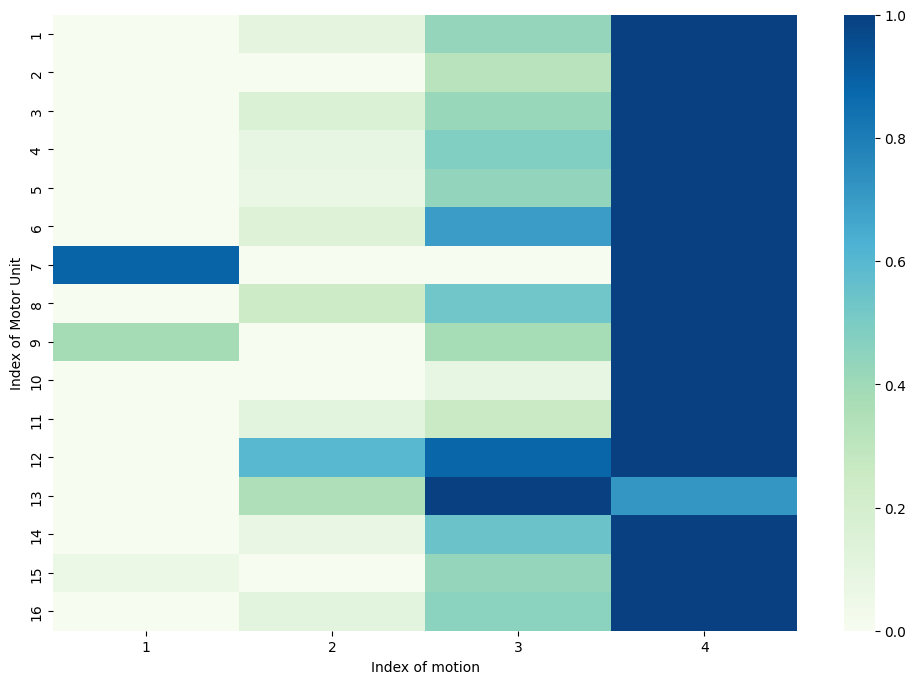

In [27]:
import seaborn as sns
plt.rcParams['figure.figsize'] = (12.0, 8.0)
 
def min_max(x, axis=None):
    min = x.min(axis=axis, keepdims=True)
    max = x.max(axis=axis, keepdims=True)
    result = (x-min)/(max-min + 1e-16)
    return result

mapping = np.array(list_meanFR_ext).T
sns.heatmap(
    min_max(mapping, axis=1),
    xticklabels=[x + 1 for x in range(mapping.shape[1])],
    yticklabels=[x + 1 for x in range(mapping.shape[0])],
    cmap='GnBu')
plt.xlabel('Index of motion')
plt.ylabel('Index of Motor Unit')

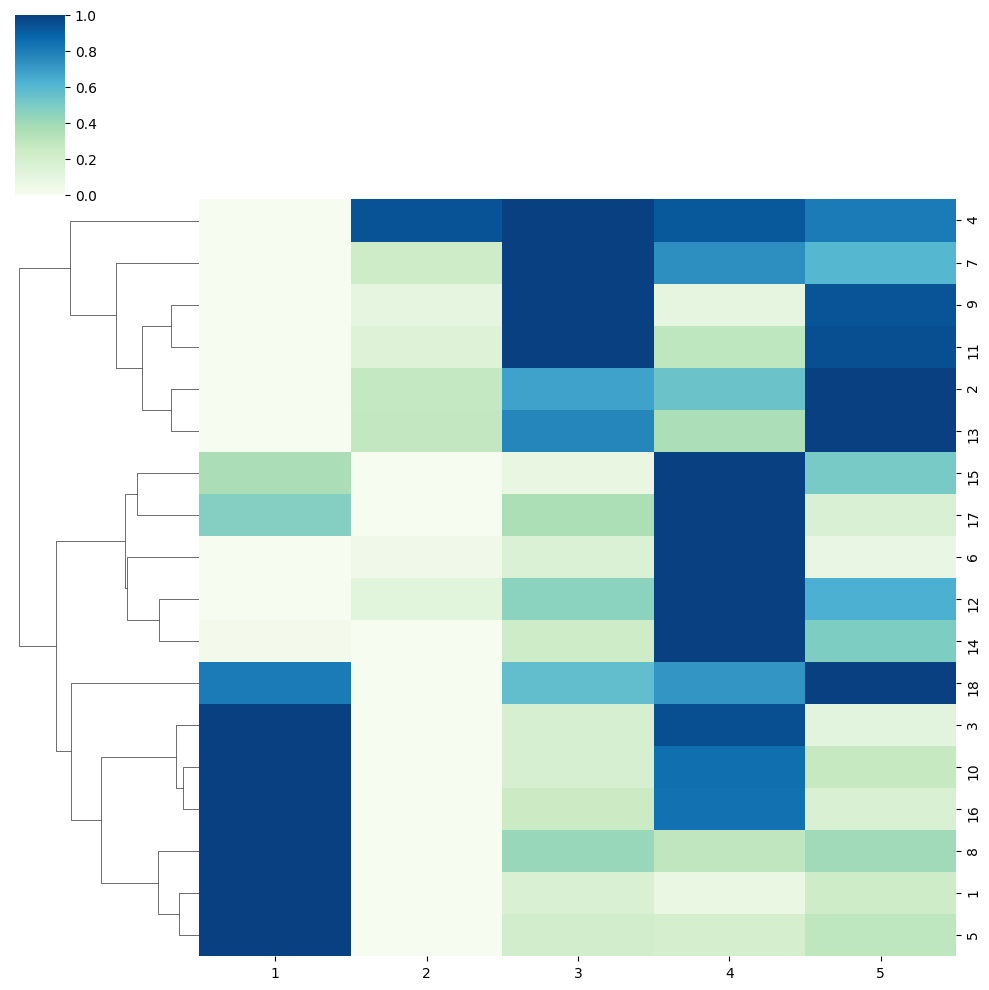

In [13]:
sns.clustermap(
    min_max(mapping, axis=1),
    xticklabels=[x + 1 for x in range(mapping.shape[1])],
    yticklabels=[x + 1 for x in range(mapping.shape[0])],
    col_cluster = False,
    cmap='GnBu')

# FR mean

202.80819093200537
247.94154859955552
151.7444476427539
451.38258023225853


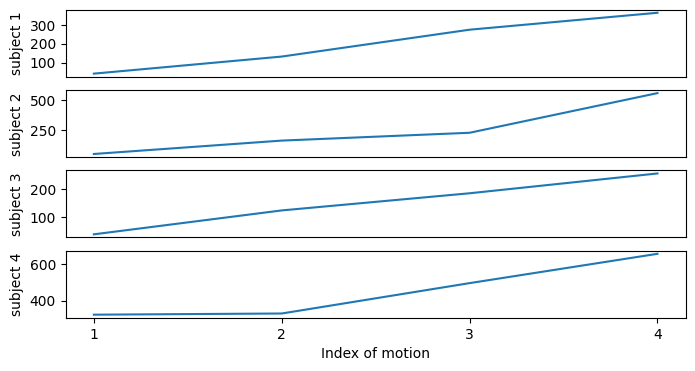

In [244]:
motion_name = 'imrl'

plt.rcParams['figure.figsize'] = (8.0, 4.0)

fig, axs = plt.subplots(4)

for j, _s in enumerate(['tei', 'li', 'nakashima', 'zhang']):
    df_meanfr = pd.read_csv(f'fr_mean/meanfr_{motion_name}_{_s}.csv', index_col=0, header=0)
    meanfr_sum = df_meanfr.values.sum(axis=0)
    axs[j].plot([x +1 for x in range(len(meanfr_sum))], meanfr_sum * 2000)
    print(meanfr_sum.mean() * 2000)
    axs[j].set_xticks(np.arange(1, len(meanfr_sum) + 1,1))
    axs[j].set_ylabel('subject ' + str(j+1))
    
    if j != 3:
        axs[j].tick_params(bottom=False, labelbottom=False)
    else:
        axs[j].set_xlabel('Index of motion')


202.80819093200537
247.94154859955552
151.7444476427539
451.38258023225853


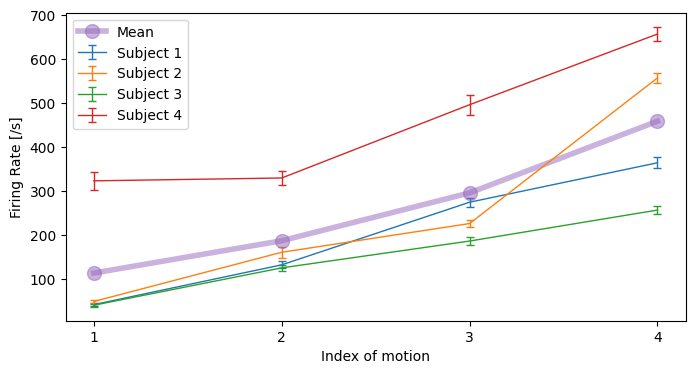

In [19]:
motion_name = 'imrl'

plt.rcParams['figure.figsize'] = (8.0, 4.0)
meanfr_all = []
for j, _s in enumerate(['tei', 'li', 'nakashima', 'zhang']):
    df_meanfr = pd.read_csv(f'fr_mean/meanfr_{motion_name}_{_s}.csv', index_col=0, header=0)
    meanfr_sum = df_meanfr.values.sum(axis=0)

    e = np.std(df_meanfr.values * 2000, axis=0)# / np.sqrt(len(df_meanfr.values))
    plt.errorbar([x +1 for x in range(len(meanfr_sum))], meanfr_sum * 2000, label='Subject ' + str(j+1), yerr=e, capthick=1, capsize=3, lw=1)

    print(meanfr_sum.mean() * 2000, )#np.std(meanfr_sum * 2000, axis=0)/ np.sqrt(len(meanfr_sum)))
    meanfr_all.append(meanfr_sum * 2000)

plt.plot([x +1 for x in range(len(meanfr_sum))], np.array(meanfr_all).mean(axis=0), label='Mean', linewidth=4, marker='o', markersize=10, alpha=0.5)

plt.xticks(np.arange(1, len(meanfr_sum) + 1,1))

plt.ylabel('Firing Rate [/s]')
plt.xlabel('Index of motion')
plt.legend()

In [20]:
np.corrcoef(
    [[142.20829933342563,210.54297150215257,177.1184290248664,285.19464352587516],
    [202.80819093200537,247.94154859955552,151.7444476427539,451.38258023225853]])

array([[1.        , 0.91126675],
       [0.91126675, 1.        ]])

# EMG,MUST,FRとか可視化

In [31]:
# param
n_motor_unit = 20
subject_name = 'tei'
motion_name = 'five'
motion_index = 1

path_root = glob.glob(f'G:/共有ドライブ/MFG/project/Biomedical engineering/Project プロジェクト/Bionic hand/EMG実験/2022*_{subject_name}')[0]
filename = df_filename[subject_name][motion_name + '_' + str(motion_index)]
path = f'{path_root}/{filename}/{filename}.rhd'
emg_filt = filt_all_rhd(path)

cashe = subject_name +'_' + filename + '_mu' + str(n_motor_unit)

emg_tmp = emg_filt[:, :64]

print('start decomp')
est_flex = EmgDecomposition(
    n_motor_unit=n_motor_unit,
    n_delayed=8,
    random_state=0,
    cashe= cashe,
    flag_sil=True,
    flag_pca=False)
est_flex.fit(emg_tmp)
st_flex, mu_flex = est_flex.transform(emg_tmp)



Reading Intan Technologies RHD2000 Data File, Version 3.0

n signal groups 11
Found 128 amplifier channels.
Found 6 auxiliary input channels.
Found 0 supply voltage channels.
Found 0 board ADC channels.
Found 0 board digital input channels.
Found 0 board digital output channels.
Found 0 temperature sensors channels.

File contains 25.664 seconds of data.  Amplifiers were sampled at 2.00 kS/s.

Allocating memory for data...
Reading data from file...
10% done...
20% done...
30% done...
40% done...
50% done...
60% done...
70% done...
80% done...
90% done...
Parsing data...
No missing timestamps in data.
Done!  Elapsed time: 0.4 seconds
start decomp


Text(0.5, 0, 'time[s]')

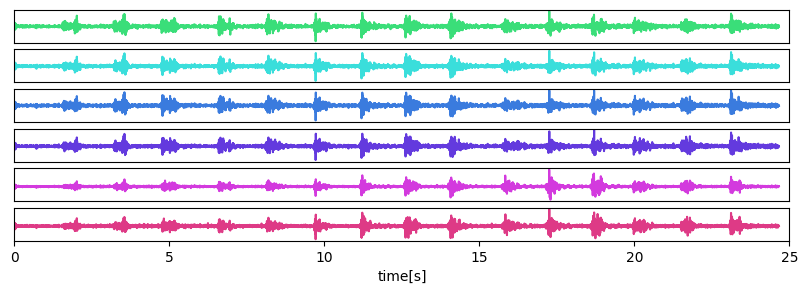

In [60]:
# EMG
emg_sample = emg_tmp[:, [0, 4, 6, 7, 60, 63]].T

plt.rcParams['figure.figsize'] = (10.0, 3.0)

cmap = ['#de3c3a', '#de9c3a', '#d8de3a', '#70de3a', '#3ade79', '#3adedb', '#3a7bde', '#633ade', '#d33ade', '#de3a86']
fig = plt.figure()
for i, mu_fr in enumerate(emg_sample):
    ax = fig.add_subplot(len(emg_sample), 1, i +1)
    ax.plot([(x)/2000 for x in range(emg_sample.shape[1])], mu_fr, color=cmap[i+4])
    ax.set_xlim(0, 25)
    ax.tick_params(
        labelbottom=False,
        labelleft=False,
        labelright=False,
        labeltop=False,
        bottom=False,
        left=False,
        right=False,
        top=False)
ax.tick_params(
    labelbottom=True,
    bottom=True)
ax.set_xlabel('time[s]')

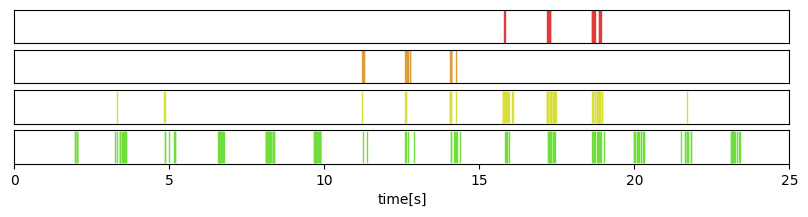

In [48]:
# MUST
def plot_spikes_subplot(spikes):
    fig = plt.figure()
    x_s = (np.arange(spikes.shape[0]) ) /2000
    cmap = ['#de3c3a', '#de9c3a', '#d8de3a', '#70de3a', '#3ade79', '#3adedb', '#3a7bde', '#633ade', '#d33ade', '#de3a86']# plt.get_cmap("tab10")
    i_c = 0
    for i in range(spikes.shape[1]):
        spike_row = spikes[:, i]
        if i_c >= len(cmap):
            i_c = 0
        color = cmap[i_c]
        i_c += 1
        ax = fig.add_subplot(spikes.shape[1], 1, i +1)
        for j in range(spikes.shape[0]):
            if spike_row[j] == 1:
                _x = x_s[j]
                ax.plot([_x, _x], [i+0.1, i+0.9], color=color, lw=1)
                ax.tick_params(
                    labelbottom=False,
                    labelleft=False,
                    labelright=False,
                    labeltop=False,
                    bottom=False,
                    left=False,
                    right=False,
                    top=False)
                ax.set_xlim(0, 25)
    ax.tick_params(
        labelbottom=True,
        bottom=True)
    ax.set_xlabel('time[s]')

plt.rcParams['figure.figsize'] = (10.0, 2.0)
plot_spikes_subplot(st_flex[:, [0, 4, 6, 11]])

Text(0.5, 0, 'time[s]')

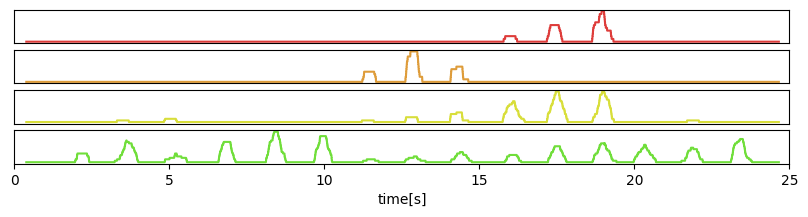

In [57]:
# FR
plt.rcParams['figure.figsize'] = (10.0, 2.0)

cmap = ['#de3c3a', '#de9c3a', '#d8de3a', '#70de3a', '#3ade79', '#3adedb', '#3a7bde', '#633ade', '#d33ade', '#de3a86']
fr_sample = st2fr( pd.DataFrame(st_flex[:, [0, 4, 6, 11]]), is_non_overlap=False).values.T
fig = plt.figure()
for i, mu_fr in enumerate(fr_sample):
    ax = fig.add_subplot(len(fr_sample), 1, i +1)
    ax.plot([(x+768)/2000 for x in range(fr_sample.shape[1])], mu_fr, color=cmap[i])
    ax.set_xlim(0, 25)
    ax.tick_params(
        labelbottom=False,
        labelleft=False,
        labelright=False,
        labeltop=False,
        bottom=False,
        left=False,
        right=False,
        top=False)
ax.tick_params(
    labelbottom=True,
    bottom=True)
ax.set_xlabel('time[s]')